# *Makeing Custom Dataset*

In [1]:
import os
import shutil

# Define paths
source_base = "/kaggle/input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
dest_base = "/kaggle/working/fruit_dataset"

# Create destination folders
categories = ['Apple_Good', 'Apple_Bad', 'Banana_Good', 'Banana_Bad', 'Guava_Good','Guava_Bad','Orange_Good','Orange_Bad']
for category in categories:
    os.makedirs(os.path.join(dest_base, category), exist_ok=True)

# Move files
def copy_files(src_folder, dest_folder):
    for img in os.listdir(src_folder):
        shutil.copy(os.path.join(src_folder, img), os.path.join(dest_folder, img))

# Good Quality
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Apple_Good"), os.path.join(dest_base, "Apple_Good"))
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Banana_Good"), os.path.join(dest_base, "Banana_Good"))
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Guava_Good"), os.path.join(dest_base, "Guava_Good"))
copy_files(os.path.join(source_base, "Good Quality_Fruits", "Orange_Good"), os.path.join(dest_base, "Orange_Good"))


# Bad Quality
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Apple_Bad"), os.path.join(dest_base, "Apple_Bad"))
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Banana_Bad"), os.path.join(dest_base, "Banana_Bad"))
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Guava_Bad"), os.path.join(dest_base, "Guava_Bad"))
copy_files(os.path.join(source_base, "Bad Quality_Fruits", "Orange_Bad"), os.path.join(dest_base, "Orange_Bad"))



# *Checking Sample*

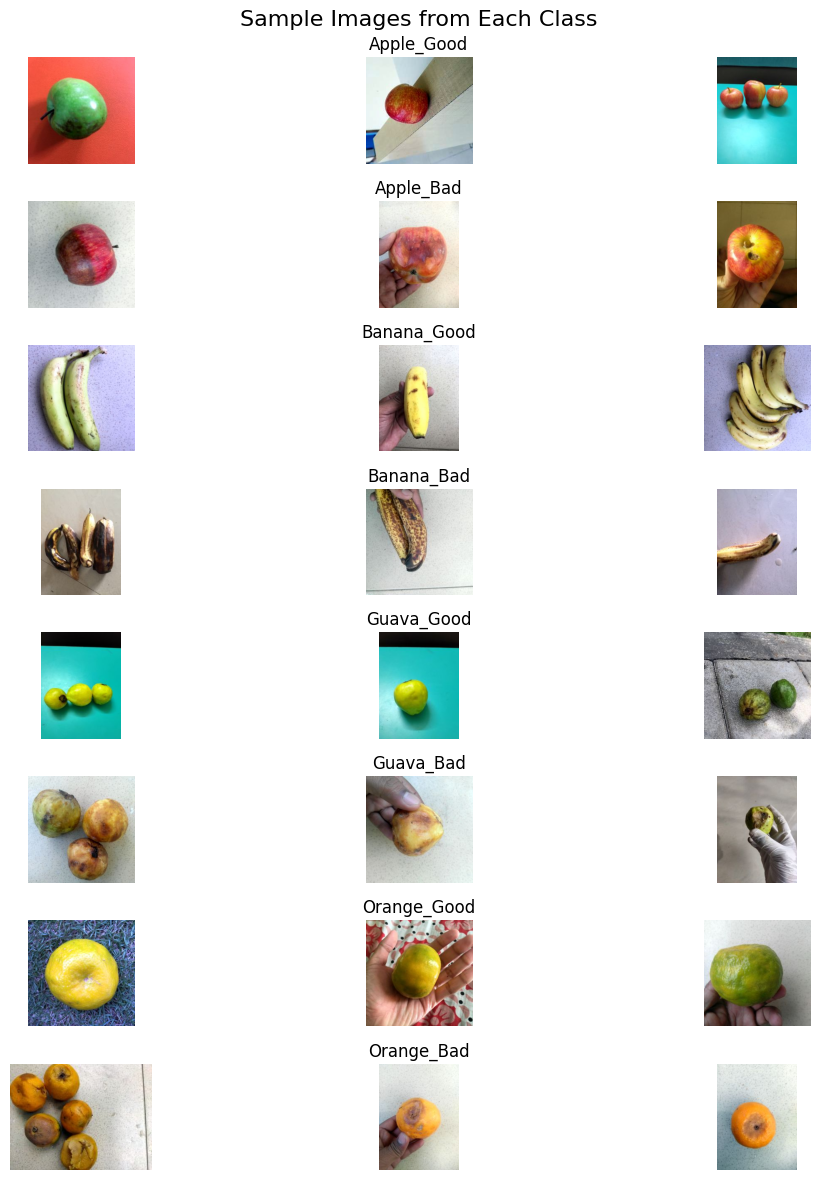

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


# Show 3 images from each category
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(12, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, category in enumerate(categories):
    class_path = os.path.join(dest_base, category)
    sample_imgs = random.sample(os.listdir(class_path), 3)
    
    for j in range(3):
        img_path = os.path.join(class_path, sample_imgs[j])
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 1:
            axes[i, j].set_title(category, fontsize=12)

plt.tight_layout()
plt.show()

# *Calculating Number Samples per each class*

In [54]:
for category in categories:
    class_dir = os.path.join(dest_base, category)
    num_images = len(os.listdir(class_dir))
    print(f"{category}: {num_images} images")


Apple_Good: 1149 images
Apple_Bad: 1141 images
Banana_Good: 1113 images
Banana_Bad: 1087 images
Guava_Good: 1152 images
Guava_Bad: 1129 images
Orange_Good: 1216 images
Orange_Bad: 1159 images


# *Train-Val Splitting*

In [55]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
original_dataset_dir = '/kaggle/working/fruit_dataset'
output_dir = '/kaggle/working/fruit_dataset_split'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Parameters
val_split = 0.2  # 20% validation

# Make output directories
for split_dir in [train_dir, val_dir]:
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Split each class separately
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    image_files = os.listdir(class_dir)
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42, shuffle=True)

    # Copy train files
    for fname in train_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(train_dir, class_name, fname)
        shutil.copyfile(src, dst)

    # Copy val files
    for fname in val_files:
        src = os.path.join(class_dir, fname)
        dst = os.path.join(val_dir, class_name, fname)
        shutil.copyfile(src, dst)

print("✅ Dataset split completed.")

✅ Dataset split completed.


# *Generating CSV for Multi-Head Classification*

In [93]:
import pandas as pd
# base directory should include both train and val
base_dirs = ['/kaggle/working/fruit_dataset_split/train', '/kaggle/working/fruit_dataset_split/val']

filenames, fruits, conditions = [], [], []

for base_dir in base_dirs:
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            try:
                fruit, condition = folder.split('_')
            except ValueError:
                print(f"Skipping folder: {folder}")
                continue

            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    relative_path = os.path.join(os.path.basename(base_dir), folder, file)
                    filenames.append(relative_path)
                    fruits.append(fruit.lower())
                    conditions.append(condition.lower())

# Create full DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'fruit': fruits,
    'condition': conditions
})

df.to_csv('/kaggle/working/full_metadata.csv', index=False)

# *Encoding*

In [94]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
fruit_encoder = LabelEncoder()
condition_encoder = LabelEncoder()

df['fruit_encoded'] = fruit_encoder.fit_transform(df['fruit'])
df['condition_encoded'] = condition_encoder.fit_transform(df['condition'])

# One-hot encode
fruit_labels = to_categorical(df['fruit_encoded'])
condition_labels = to_categorical(df['condition_encoded'])

In [95]:
# Add individual columns for one-hot encoded labels
fruit_classes = pd.DataFrame(fruit_labels, columns=[f'fruit_{cls}' for cls in fruit_encoder.classes_])
condition_classes = pd.DataFrame(condition_labels, columns=[f'condition_{cls}' for cls in condition_encoder.classes_])

df = pd.concat([df, fruit_classes, condition_classes], axis=1)


fruit_cols = [col for col in df.columns if col.startswith('fruit_')]
cond_cols = [col for col in df.columns if col.startswith('condition_')]

# *Data Augmentation*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
   rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3, 
    horizontal_flip=True,
    vertical_flip=True, 
    brightness_range=[0.7, 1.3], 
    channel_shift_range=20.0, 
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_df = df[df['filename'].str.startswith('train')]
val_df = df[df['filename'].str.startswith('val')]

fruit_cols = fruit_classes.columns.tolist()
cond_cols = condition_classes.columns.tolist()

combined_y_cols = fruit_cols + cond_cols

train_generator_raw = train_datagen.flow_from_dataframe(
    train_df,
    directory='/kaggle/working/fruit_dataset_split',
    x_col='filename',
    y_col=combined_y_cols,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)
val_generator_raw = val_datagen.flow_from_dataframe(
    val_df,
    directory='/kaggle/working/fruit_dataset_split',
    x_col='filename',
    y_col=combined_y_cols,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)


Found 7313 validated image filenames.
Found 1833 validated image filenames.


In [97]:
print("Train fruit classes:", train_df['fruit'].unique())
print("Val fruit classes:", val_df['fruit'].unique())

Train fruit classes: ['banana' 'apple' 'guava' 'orange']
Val fruit classes: ['banana' 'apple' 'guava' 'orange']


In [ ]:
def split_generator(generator, fruit_dim):
    for x_batch, y_batch in generator:
        fruit_labels = y_batch[:, :fruit_dim]
        condition_labels = y_batch[:, fruit_dim:]
        yield x_batch, (fruit_labels, condition_labels)

# Convert generator to tf.data.Dataset
def create_dataset(generator, fruit_dim):
    dataset = tf.data.Dataset.from_generator(
        lambda: split_generator(generator, fruit_dim),
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  
            (
                tf.TensorSpec(shape=(None, 4), dtype=tf.float32), 
                tf.TensorSpec(shape=(None, 2), dtype=tf.float32)  
            )
        )
    )
    return dataset


train_dataset = create_dataset(train_generator_raw, fruit_dim=len(fruit_cols))
val_dataset = create_dataset(val_generator_raw, fruit_dim=len(fruit_cols))

In [ ]:
print(len(fruit_cols)) 
print(fruit_cols)

4
['fruit_apple', 'fruit_banana', 'fruit_guava', 'fruit_orange']


In [ ]:
# def residual_block(x, filters):
#     shortcut = x
#     x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut) 
#     x = layers.Add()([shortcut, x])
#     x = layers.Activation('relu')(x)
#     return x

In [ ]:
from tensorflow.keras import layers, models, Input, Model, regularizers


input_layer = Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
fruit_output = layers.Dense(4, activation='softmax', name='fruit')(x)
condition_output = layers.Dense(2, activation='softmax', name='condition')(x)
model = Model(inputs=input_layer, outputs=[fruit_output, condition_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        'fruit': 'categorical_crossentropy',
        'condition': 'categorical_crossentropy'
    },
    loss_weights={'fruit': 1.5, 'condition': 1.0},
    metrics={'fruit': 'accuracy', 'condition': 'accuracy'}
)

# model.summary()


In [108]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=2000, mode='triangular'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        return self.base_lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        self.clr_iterations = 0
        self.model.optimizer.lr = self.base_lr

    def on_batch_end(self, batch, logs=None):
        self.trn_iterations += 1
        self.clr_iterations += 1
        lr = self.clr()
        self.model.optimizer.lr = lr
        self.history.setdefault('lr', []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

clr = CyclicLR(base_lr=1e-5, max_lr=1e-3, step_size=2000)

In [109]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=len(train_generator_raw),
    validation_steps=len(val_generator_raw),
    epochs=50,
    verbose=1, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        reduce_lr,
        clr
    ]
)

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 108s 428ms/step - condition_accuracy: 0.7891 - condition_loss: 0.7047 - fruit_accuracy: 0.4914 - fruit_loss: 1.1869 - loss: 5.1776 - val_condition_accuracy: 0.4937 - val_condition_loss: 1.3358 - val_fruit_accuracy: 0.2657 - val_fruit_loss: 1.3474 - val_loss: 5.6322 - learning_rate: 1.0000e-04
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 92s 402ms/step - condition_accuracy: 0.8837 - condition_loss: 0.4480 - fruit_accuracy: 0.7462 - fruit_loss: 0.7001 - loss: 3.9749 - val_condition_accuracy: 0.8663 - val_condition_loss: 0.5330 - val_fruit_accuracy: 0.6907 - val_fruit_loss: 0.8371 - val_loss: 3.8893 - learning_rate: 1.0000e-04
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 91s 399ms/step - condition_accuracy: 0.8979 - condition_loss: 0.3774 - fruit_accuracy: 0.7940 - fruit_loss: 0.5657 - loss: 3.3697 - val_condition_accuracy: 0.9285 - val_condition_loss: 0.2858 - val_fruit_accuracy: 0.8418 - val_fruit_loss: 0.4845 - val_loss: 2.9319 - learning_rate: 1.0000e-04


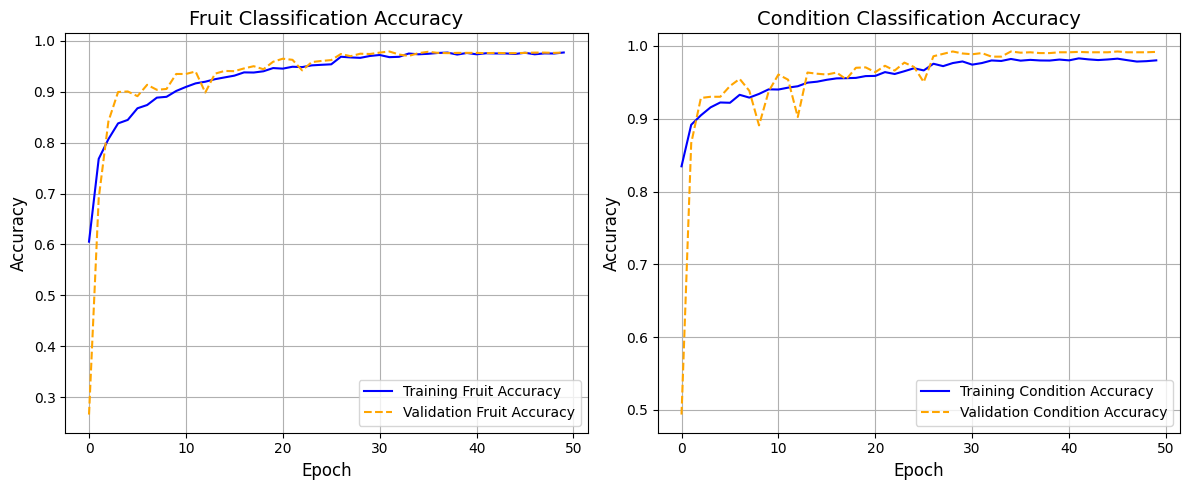

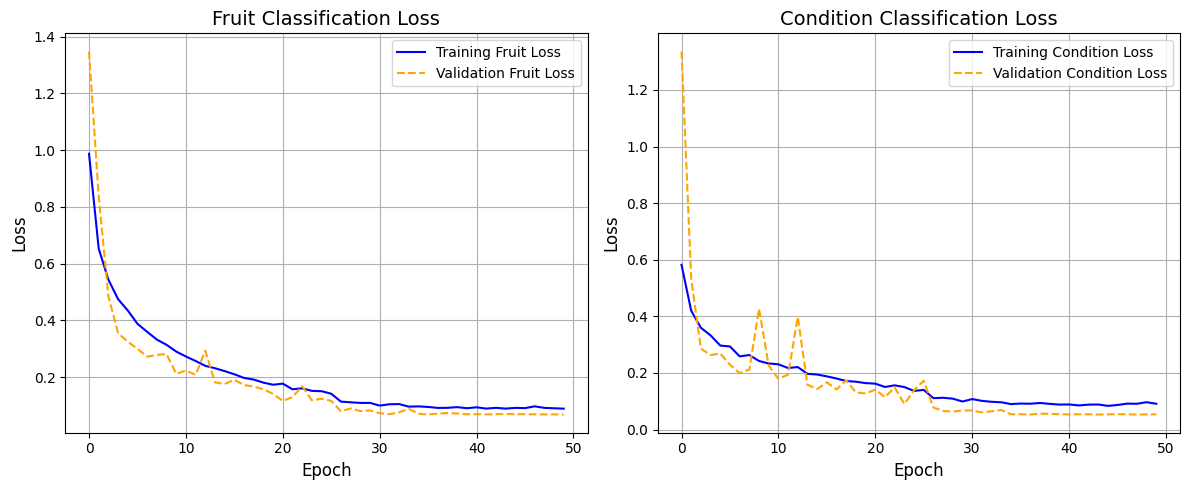

In [ ]:
import matplotlib.pyplot as plt

# Create figure with two subplots for accuracy
plt.figure(figsize=(12, 5))

# Plot Fruit Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['fruit_accuracy'], label='Training Fruit Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_fruit_accuracy'], label='Validation Fruit Accuracy', color='orange', linestyle='--')
plt.title('Fruit Classification Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)

# Plot Condition Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['condition_accuracy'], label='Training Condition Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_condition_accuracy'], label='Validation Condition Accuracy', color='orange', linestyle='--')
plt.title('Condition Classification Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/accuracy_curves.png', dpi=300) 
plt.show()

# Create figure with two subplots for loss
plt.figure(figsize=(12, 5))

# Plot Fruit Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['fruit_loss'], label='Training Fruit Loss', color='blue', linestyle='-')
plt.plot(history.history['val_fruit_loss'], label='Validation Fruit Loss', color='orange', linestyle='--')
plt.title('Fruit Classification Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)

# Plot Condition Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['condition_loss'], label='Training Condition Loss', color='blue', linestyle='-')
plt.plot(history.history['val_condition_loss'], label='Validation Condition Loss', color='orange', linestyle='--')
plt.title('Condition Classification Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig('/kaggle/working/loss_curves.png', dpi=300)
plt.show()

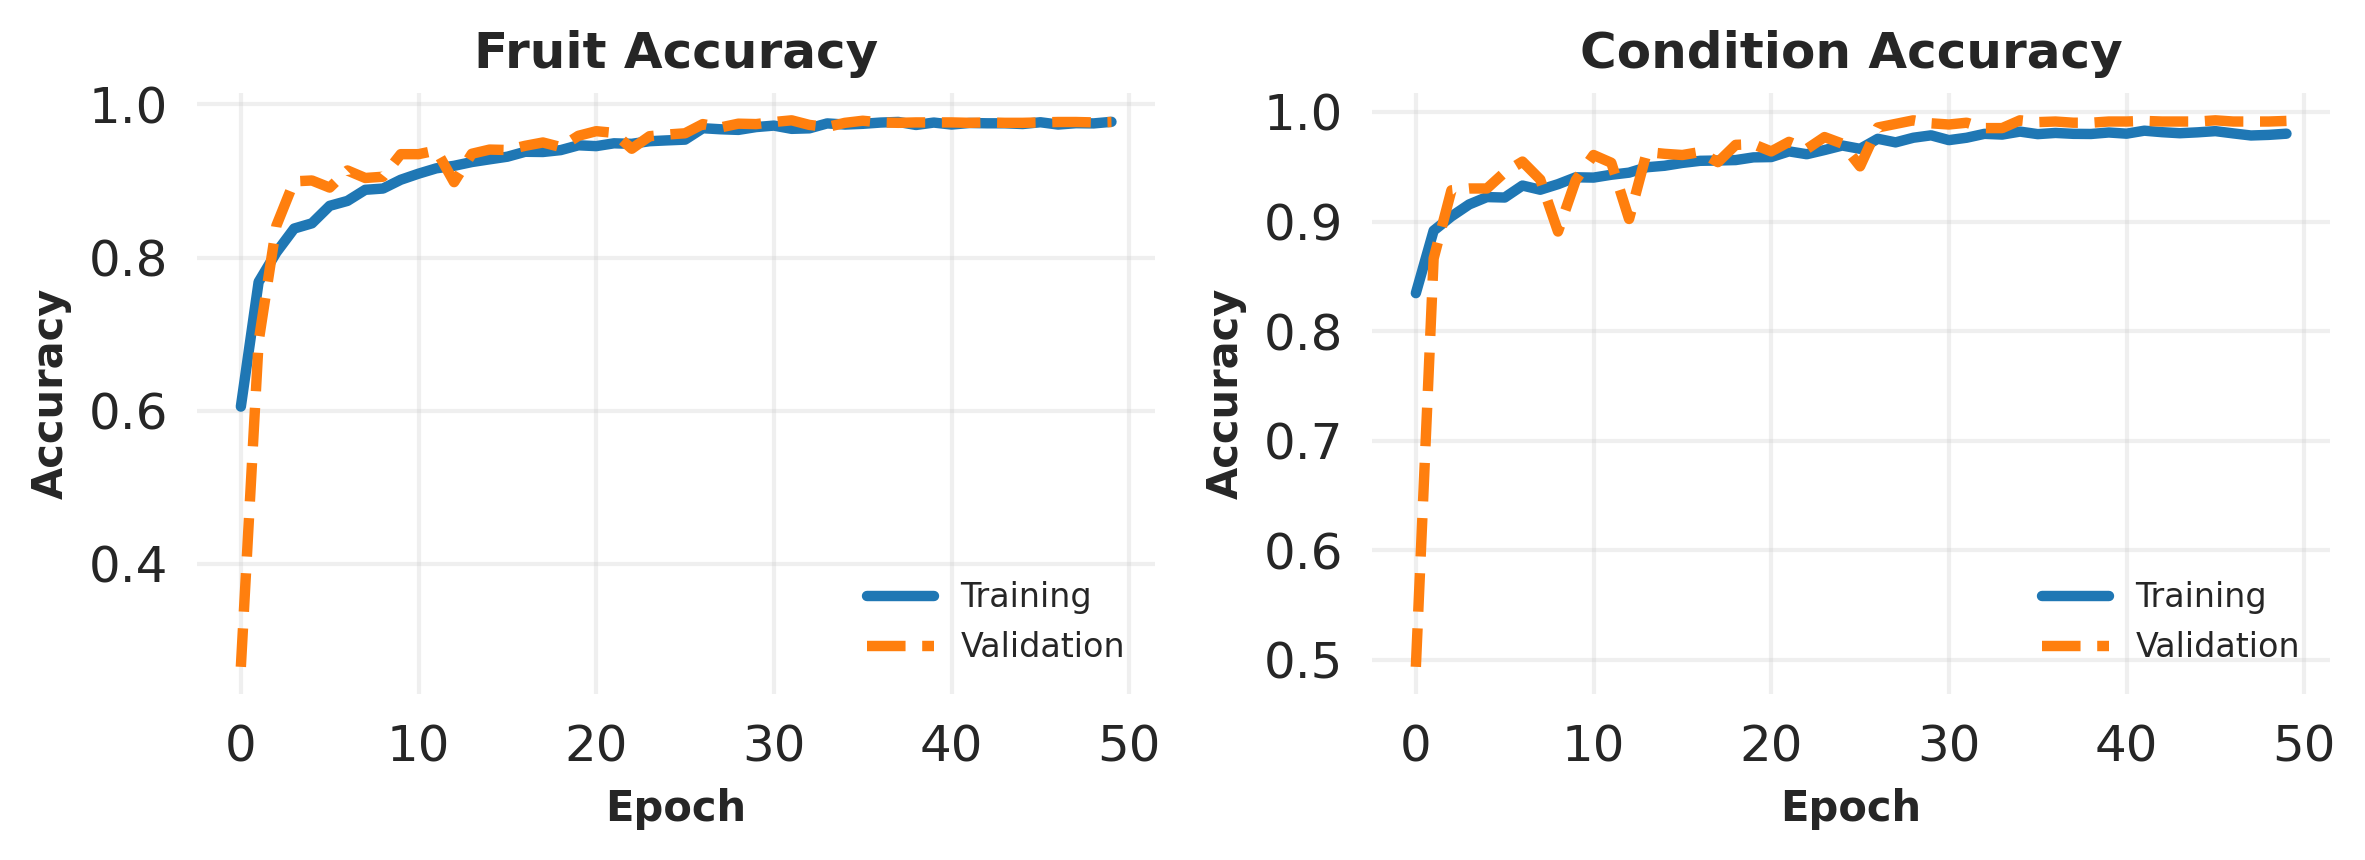

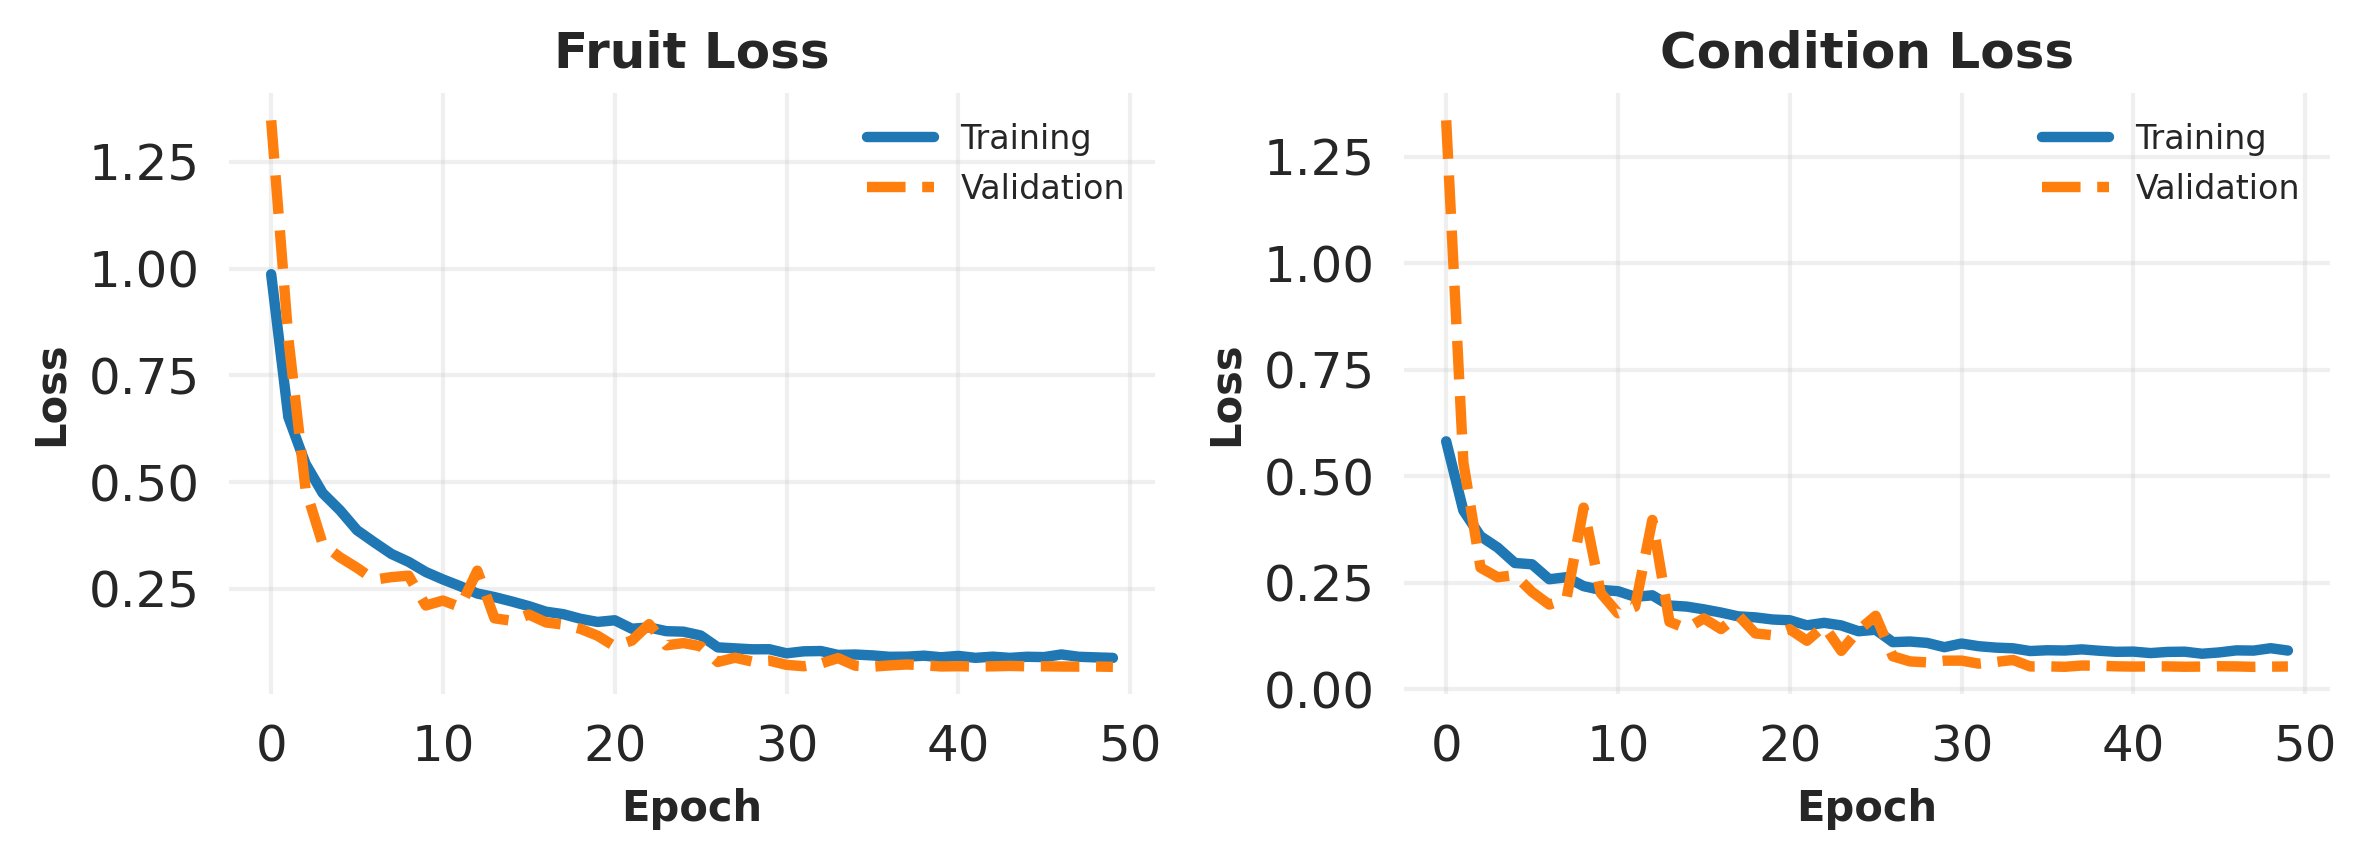

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for professional look
sns.set_style("whitegrid")


# Create figure with two subplots for accuracy
plt.figure(figsize=(8, 3))  # Compact size for paper

# Plot Fruit Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['fruit_accuracy'], label='Training', color='#1f77b4', linewidth=2.5)
plt.plot(history.history['val_fruit_accuracy'], label='Validation', color='#ff7f0e', linewidth=2.5, linestyle='--')
plt.title('Fruit Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Accuracy', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

# Plot Condition Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['condition_accuracy'], label='Training', color='#1f77b4', linewidth=2.5)
plt.plot(history.history['val_condition_accuracy'], label='Validation', color='#ff7f0e', linewidth=2.5, linestyle='--')
plt.title('Condition Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Accuracy', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

plt.tight_layout(pad=1.0)
plt.savefig('/kaggle/working/accuracy_curves_bold.png', dpi=300, bbox_inches='tight')
plt.show()

# Create figure with two subplots for loss
plt.figure(figsize=(8, 3))  

# Plot Fruit Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['fruit_loss'], label='Training', color='#1f77b4', linewidth=2.5)
plt.plot(history.history['val_fruit_loss'], label='Validation', color='#ff7f0e', linewidth=2.5, linestyle='--')
plt.title('Fruit Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Loss', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

# Plot Condition Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['condition_loss'], label='Training', color='#1f77b4', linewidth=2.5)
plt.plot(history.history['val_condition_loss'], label='Validation', color='#ff7f0e', linewidth=2.5, linestyle='--')
plt.title('Condition Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Loss', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)

plt.tight_layout(pad=1.0)
plt.savefig('/kaggle/working/loss_curves_bold.png', dpi=300, bbox_inches='tight')
plt.show()

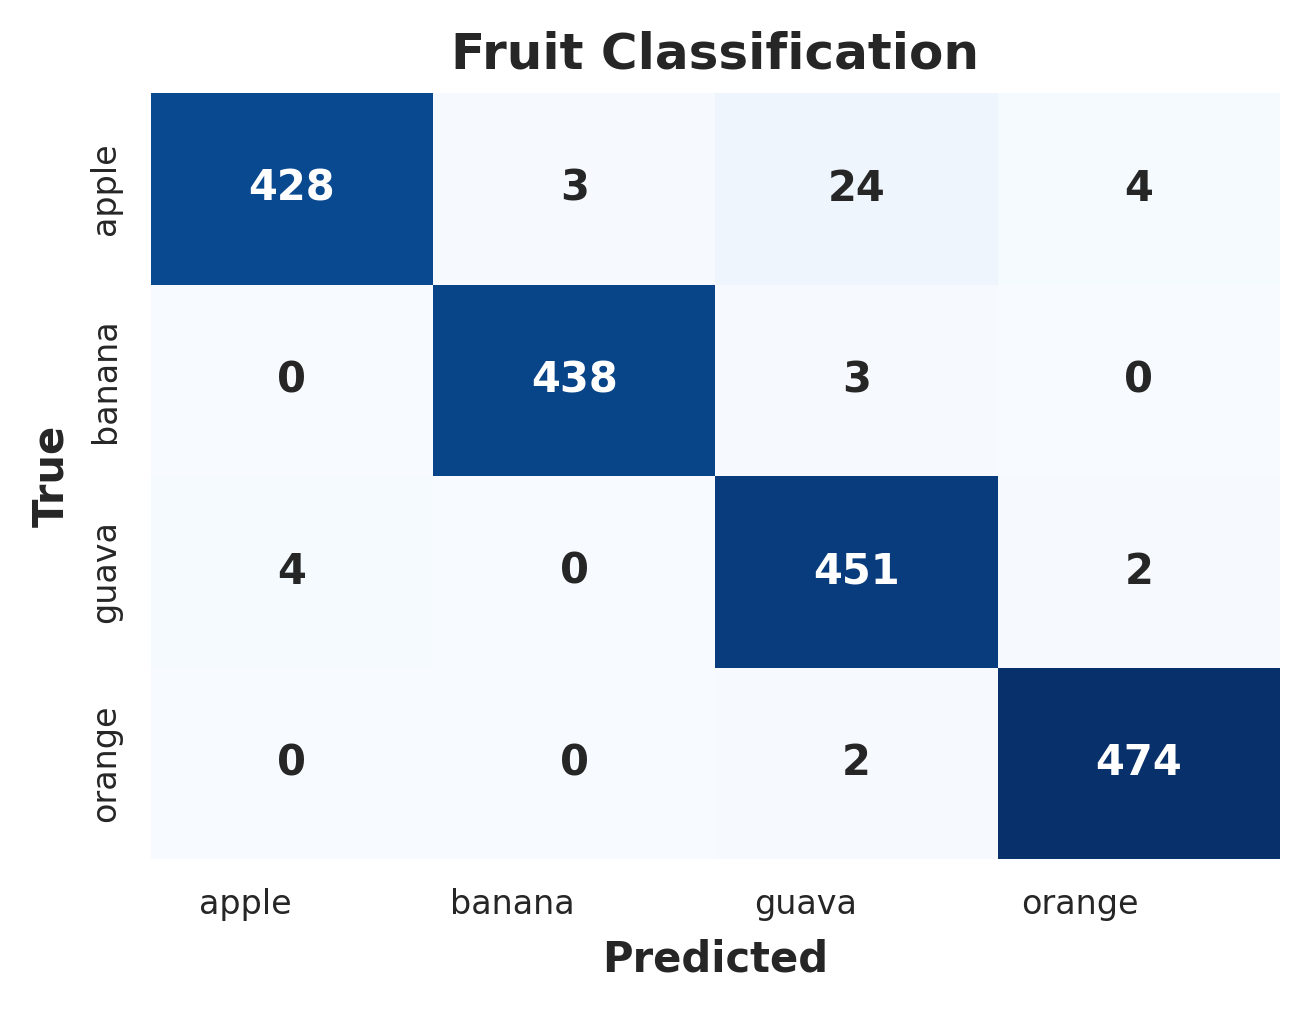

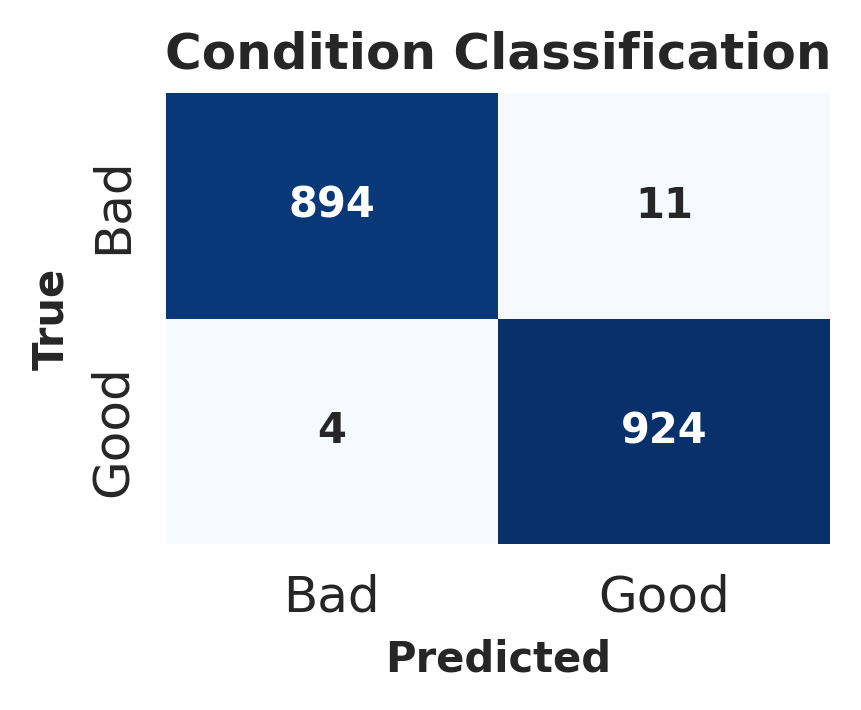

In [123]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define dict_generator function
def dict_generator(generator, fruit_dim):
    for x_batch, y_batch in generator:
        yield x_batch, {
            'fruit': y_batch[:, :fruit_dim],
            'condition': y_batch[:, fruit_dim:]
        }

# Re-create val_gen to ensure fresh iteration
val_generator_raw.reset()  # Reset the Keras generator
val_gen = dict_generator(val_generator_raw, fruit_dim=len(fruit_cols))

# Collect true and predicted labels
y_true_fruit = []
y_true_condition = []
y_pred_fruit = []
y_pred_condition = []

# Iterate through val_gen to get predictions
for _ in range(len(val_generator_raw)):
    x_batch, y_batch = next(val_gen)
    predictions = model.predict(x_batch, verbose=0)
    
    # True labels from dict_generator output
    y_true_fruit.extend(np.argmax(y_batch['fruit'], axis=1))
    y_true_condition.extend(np.argmax(y_batch['condition'], axis=1))
    
    # Predicted labels
    y_pred_fruit.extend(np.argmax(predictions[0], axis=1))  # Fruit predictions
    y_pred_condition.extend(np.argmax(predictions[1], axis=1))  # Condition predictions

# Convert to numpy arrays
y_true_fruit = np.array(y_true_fruit)
y_true_condition = np.array(y_true_condition)
y_pred_fruit = np.array(y_pred_fruit)
y_pred_condition = np.array(y_pred_condition)

# Compute confusion matrices
cm_fruit = confusion_matrix(y_true_fruit, y_pred_fruit)
cm_condition = confusion_matrix(y_true_condition, y_pred_condition)

# Set Seaborn style for professional look
sns.set_style("whitegrid")

# Plot Fruit Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(4.5, 3.5))  # Slightly larger for label spacing
sns.heatmap(cm_fruit, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=fruit_encoder.classes_, yticklabels=fruit_encoder.classes_,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Fruit Classification', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=10, fontweight='bold')
plt.ylabel('True', fontsize=10, fontweight='bold')
plt.xticks(ha='right', fontsize=8)  # Rotate x-axis labels
plt.yticks(fontsize=8)  # Smaller y-axis font size
plt.tight_layout(pad=1.0)
plt.savefig('/kaggle/working/fruit_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Condition Confusion Matrix (unchanged)
plt.figure(figsize=(3, 2.5))  # Smaller size for 2x2 matrix
sns.heatmap(cm_condition, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'],
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Condition Classification', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=10, fontweight='bold')
plt.ylabel('True', fontsize=10, fontweight='bold')
plt.tight_layout(pad=1.0)
plt.savefig('/kaggle/working/condition_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [125]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Define dict_generator function
def dict_generator(generator, fruit_dim):
    for x_batch, y_batch in generator:
        yield x_batch, {
            'fruit': y_batch[:, :fruit_dim],
            'condition': y_batch[:, fruit_dim:]
        }

# Re-create val_gen to ensure fresh iteration
val_generator_raw.reset()  # Reset the Keras generator
val_gen = dict_generator(val_generator_raw, fruit_dim=len(fruit_cols))

# Collect true and predicted labels
y_true_fruit = []
y_true_condition = []
y_pred_fruit = []
y_pred_condition = []

# Iterate through val_gen to get predictions
for _ in range(len(val_generator_raw)):
    x_batch, y_batch = next(val_gen)
    predictions = model.predict(x_batch, verbose=0)
    
    # True labels from dict_generator output
    y_true_fruit.extend(np.argmax(y_batch['fruit'], axis=1))
    y_true_condition.extend(np.argmax(y_batch['condition'], axis=1))
    
    # Predicted labels
    y_pred_fruit.extend(np.argmax(predictions[0], axis=1))  # Fruit predictions
    y_pred_condition.extend(np.argmax(predictions[1], axis=1))  # Condition predictions

# Convert to numpy arrays
y_true_fruit = np.array(y_true_fruit)
y_true_condition = np.array(y_true_condition)
y_pred_fruit = np.array(y_pred_fruit)
y_pred_condition = np.array(y_pred_condition)

# Generate classification reports
fruit_report = classification_report(y_true_fruit, y_pred_fruit, target_names=fruit_encoder.classes_, output_dict=True)
condition_report = classification_report(y_true_condition, y_pred_condition, target_names=['Bad', 'Good'], output_dict=True)

# Convert to DataFrames with custom formatting
fruit_df = pd.DataFrame(fruit_report).transpose()
fruit_df['precision'] = fruit_df['precision'].round(2)
fruit_df['recall'] = fruit_df['recall'].round(2)
fruit_df['f1-score'] = fruit_df['f1-score'].round(2)
fruit_df['support'] = fruit_df['support'].astype(int)  # Keep support as integer

condition_df = pd.DataFrame(condition_report).transpose()
condition_df['precision'] = condition_df['precision'].round(2)
condition_df['recall'] = condition_df['recall'].round(2)
condition_df['f1-score'] = condition_df['f1-score'].round(2)
condition_df['support'] = condition_df['support'].astype(int)  # Keep support as integer

# Print fruit classification report
print("Fruit Classification Report:")
print(fruit_df[['precision', 'recall', 'f1-score', 'support']])

# Print condition classification report
print("\nCondition Classification Report:")
print(condition_df[['precision', 'recall', 'f1-score', 'support']])

# Save reports as Markdown tables for paper
with open('/kaggle/working/fruit_classification_report.md', 'w') as f:
    f.write("### Fruit Classification Report\n")
    f.write(fruit_df[['precision', 'recall', 'f1-score', 'support']].to_markdown(index=True, floatfmt=".2f"))

with open('/kaggle/working/condition_classification_report.md', 'w') as f:
    f.write("### Condition Classification Report\n")
    f.write(condition_df[['precision', 'recall', 'f1-score', 'support']].to_markdown(index=True, floatfmt=".2f"))

# LaTeX table for fruit classification
fruit_latex = fruit_df[['precision', 'recall', 'f1-score', 'support']].to_latex(
    index=True, caption="Fruit Classification Metrics", label="tab:fruit_metrics", float_format="%.2f"
)
with open('/kaggle/working/fruit_classification_report.tex', 'w') as f:
    f.write(fruit_latex)

# LaTeX table for condition classification
condition_latex = condition_df[['precision', 'recall', 'f1-score', 'support']].to_latex(
    index=True, caption="Condition Classification Metrics", label="tab:condition_metrics", float_format="%.2f"
)
with open('/kaggle/working/condition_classification_report.tex', 'w') as f:
    f.write(condition_latex)

Fruit Classification Report:
              precision  recall  f1-score  support
apple              0.99    0.93      0.96      459
banana             0.99    0.99      0.99      441
guava              0.94    0.99      0.96      457
orange             0.99    1.00      0.99      476
accuracy           0.98    0.98      0.98        0
macro avg          0.98    0.98      0.98     1833
weighted avg       0.98    0.98      0.98     1833

Condition Classification Report:
              precision  recall  f1-score  support
Bad                1.00    0.99      0.99      905
Good               0.99    1.00      0.99      928
accuracy           0.99    0.99      0.99        0
macro avg          0.99    0.99      0.99     1833
weighted avg       0.99    0.99      0.99     1833


In [126]:
model.summary()
print([layer.name for layer in model.layers if 'conv2d' in layer.name.lower()])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 224, 224, 32)   │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 112, 112, 32)   │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 112, 112, 64)   │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 56, 56, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 28, 28, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 28, 28, 256)    │          1,024 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 14, 14, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_23[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)      

 Total params: 1,573,076 (6.00 MB)

 Trainable params: 524,038 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,048,078 (4.00 MB)

['conv2d_26', 'conv2d_27', 'conv2d_28', 'conv2d_29']


TensorFlow version: 2.18.0
Model summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 224, 224, 32)   │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 112, 112, 32)   │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 112, 112, 64)   │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 56, 56, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 28, 28, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 28, 28, 256)    │          1,024 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 14, 14, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ max_pooling2d_23[0][0] │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)      

 Total params: 1,573,076 (6.00 MB)

 Trainable params: 524,038 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,048,078 (4.00 MB)

Layer names: ['input_layer_8', 'conv2d_26', 'batch_normalization_8', 'max_pooling2d_20', 'conv2d_27', 'batch_normalization_9', 'max_pooling2d_21', 'conv2d_28', 'batch_normalization_10', 'max_pooling2d_22', 'conv2d_29', 'batch_normalization_11', 'max_pooling2d_23', 'global_average_pooling2d_8', 'dense_7', 'dropout_7', 'fruit', 'condition']
Model built successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Dummy prediction output shapes: [(1, 4), (1, 2)]
Model initialized successfully.
Image array shape: (1, 224, 224, 3) Min: 0.0 Max: 1.0
Using last convolutional layer: conv2d_29
Found layer: conv2d_29
Grad-CAM sub-model created for output: fruit
Image converted to tf.Tensor with shape: (1, 224, 224, 3)
Pooled gradients shape: (256,)
Found layer: conv2d_29
Grad-CAM sub-model created for output: condition
Image converted to tf.Tensor with shape: (1, 224, 224, 3)
Pooled gradients shape: (256,)
Predicted fruit class: apple
Predicted condition class: Bad


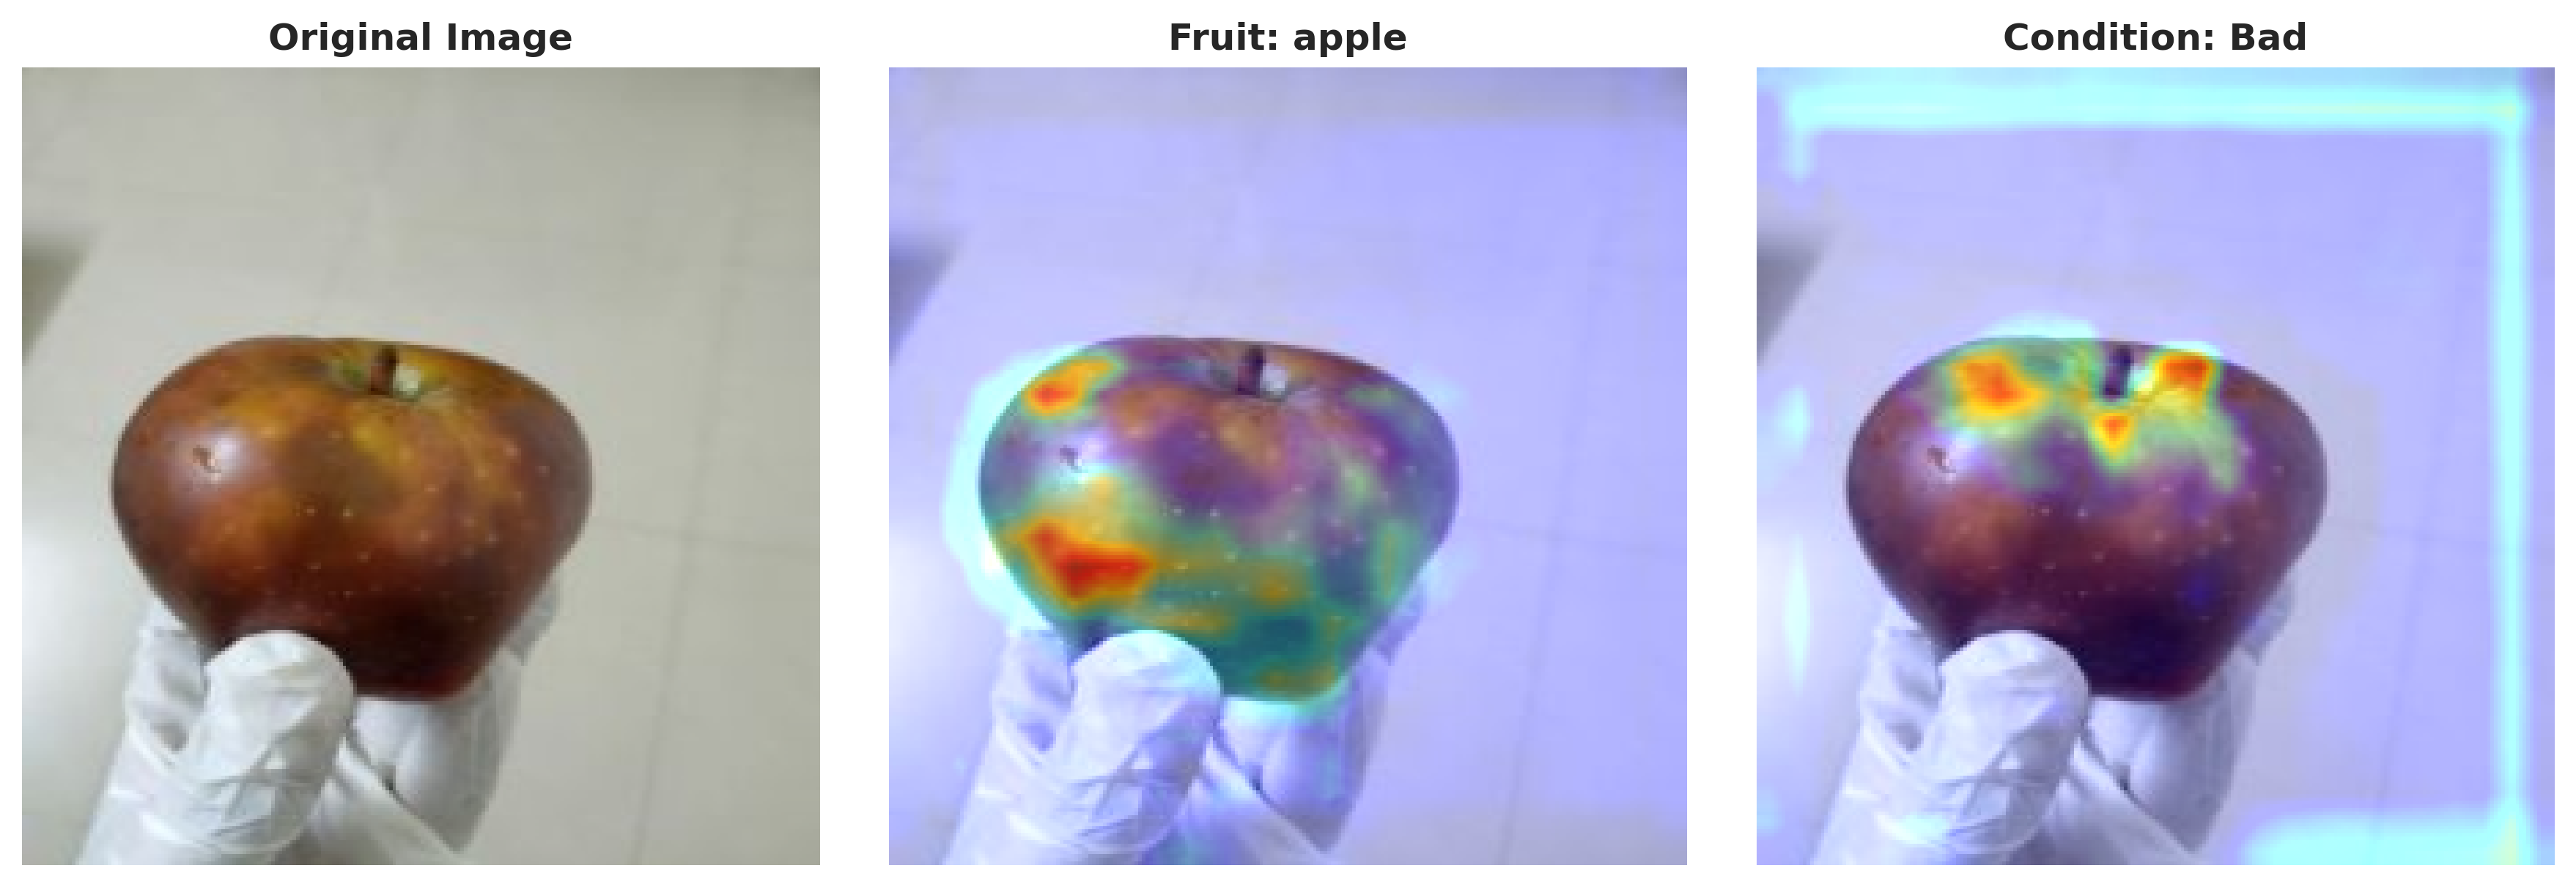

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to initialize model
def initialize_model(model, input_shape=(224, 224, 3)):
    try:
        # Explicitly build the model
        model.build((None, *input_shape))
        print("Model built successfully.")
        
        # Perform a dummy forward pass
        dummy_input = np.random.rand(1, *input_shape).astype(np.float32)
        outputs = model.predict(dummy_input)
        print("Dummy prediction output shapes:", [output.shape for output in outputs])
        print("Model initialized successfully.")
    except Exception as e:
        print(f"Error during model initialization: {e}")
        raise e

# Function to get Grad-CAM heatmap for a specific output
def direct_gradcam_heatmap(model, img_array, last_conv_layer_name, output_name, pred_index=None):
    try:
        # Get the last convolutional layer
        conv_layer = model.get_layer(last_conv_layer_name)
        print(f"Found layer: {last_conv_layer_name}")
        
        # Create a sub-model from input to conv_layer and output
        grad_model = tf.keras.Model(
            inputs=model.inputs,
            outputs=[conv_layer.output, model.get_layer(output_name).output]
        )
        print(f"Grad-CAM sub-model created for output: {output_name}")
        
        # Convert img_array to tf.Tensor
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        print(f"Image converted to tf.Tensor with shape: {img_tensor.shape}")
        
        # Compute gradients
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            conv_outputs, preds = grad_model(img_tensor)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        
        grads = tape.gradient(class_channel, conv_outputs)
        if grads is None:
            raise ValueError(f"Gradients are None for {output_name}. Check model connectivity.")
        
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        print(f"Pooled gradients shape: {pooled_grads.shape}")
        
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        return heatmap.numpy(), pred_index
    except Exception as e:
        print(f"Error in direct Grad-CAM for {output_name}: {e}")
        raise e

# Function to display and save original image and Grad-CAM heatmaps
def display_gradcam(img_path, heatmap_fruit, heatmap_condition, fruit_class, condition_class, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at {img_path}")
    img = cv2.resize(img, (224, 224))
    
    # Create Grad-CAM heatmaps
    heatmap_fruit = cv2.resize(heatmap_fruit, (224, 224))
    heatmap_fruit = np.uint8(255 * heatmap_fruit)
    heatmap_fruit = cv2.applyColorMap(heatmap_fruit, cv2.COLORMAP_JET)
    superimposed_fruit = heatmap_fruit * alpha + img
    superimposed_fruit = np.clip(superimposed_fruit, 0, 255).astype(np.uint8)
    
    heatmap_condition = cv2.resize(heatmap_condition, (224, 224))
    heatmap_condition = np.uint8(255 * heatmap_condition)
    heatmap_condition = cv2.applyColorMap(heatmap_condition, cv2.COLORMAP_JET)
    superimposed_condition = heatmap_condition * alpha + img
    superimposed_condition = np.clip(superimposed_condition, 0, 255).astype(np.uint8)
    
    # Display images
    plt.figure(figsize=(12, 4), dpi=300)
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Fruit Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(superimposed_fruit, cv2.COLOR_BGR2RGB))
    plt.title(f'Fruit: {fruit_class}', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Condition Grad-CAM
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_condition, cv2.COLOR_BGR2RGB))
    plt.title(f'Condition: {condition_class}', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Save figure
    plt.tight_layout(pad=1.0)
    plt.savefig('/kaggle/working/gradcam_two_headed_apple_bad.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
try:
    # Print TensorFlow version
    print(f"TensorFlow version: {tf.__version__}")

    # Print model summary and layer names
    print("Model summary:")
    model.summary()
    print("Layer names:", [layer.name for layer in model.layers])

    # Initialize model
    initialize_model(model)

    # Load and preprocess image
    img_path = '/kaggle/working/fruit_dataset_split/val/Apple_Bad/IMG20200728175908.jpg'
    img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img_array)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    print("Image array shape:", img_array.shape, "Min:", img_array.min(), "Max:", img_array.max())

    # Use the last convolutional layer
    last_conv_layer_name = 'conv2d_29'
    print(f"Using last convolutional layer: {last_conv_layer_name}")

    # Generate Grad-CAM heatmaps
    heatmap_fruit, fruit_pred_index = direct_gradcam_heatmap(model, img_array, last_conv_layer_name, output_name='fruit')
    heatmap_condition, condition_pred_index = direct_gradcam_heatmap(model, img_array, last_conv_layer_name, output_name='condition')

    # Class names
    fruit_classes = fruit_encoder.classes_
    condition_classes = ['Bad', 'Good']
    fruit_class = fruit_classes[fruit_pred_index]
    condition_class = condition_classes[condition_pred_index]
    print(f"Predicted fruit class: {fruit_class}")
    print(f"Predicted condition class: {condition_class}")

    # Display and save Grad-CAM
    display_gradcam(img_path, heatmap_fruit, heatmap_condition, fruit_class, condition_class)

except Exception as e:
    print(f"Error during Grad-CAM: {e}")

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Step 1: Save the model in HDF5 format
def save_model_h5(model, save_path='/kaggle/working/fruit_condition_model.h5'):
    try:
        # Save the entire model (architecture + weights)
        model.save(save_path)
        print(f"Model saved in HDF5 format at: {save_path}")
        
        # Verify by loading and testing
        loaded_model = tf.keras.models.load_model(save_path)
        dummy_input = np.random.rand(1, 224, 224, 3).astype(np.float32)
        predictions = loaded_model.predict(dummy_input)
        print("Loaded model predictions shapes:", [pred.shape for pred in predictions])
        print("HDF5 model verified successfully.")
    except Exception as e:
        print(f"Error saving/loading HDF5 model: {e}")
        raise e

# Step 2: Save the fruit_encoder classes
def save_fruit_encoder(fruit_encoder, path='/kaggle/working/fruit_encoder_classes.npy'):
    try:
        np.save(path, fruit_encoder.classes_)
        print(f"Fruit encoder classes saved at: {path}")
        
        # Verify by loading
        loaded_classes = np.load(path, allow_pickle=True)
        print("Loaded fruit encoder classes:", loaded_classes)
    except Exception as e:
        print(f"Error saving/loading fruit encoder: {e}")
        raise e

# Execute saving functions
try:
    # Save the model
    save_model_h5(model)
    
    # Save fruit_encoder classes
    save_fruit_encoder(fruit_encoder)
except Exception as e:
    print(f"Error during saving: {e}")

Model saved in HDF5 format at: /kaggle/working/fruit_condition_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Loaded model predictions shapes: [(1, 4), (1, 2)]
HDF5 model verified successfully.
Fruit encoder classes saved at: /kaggle/working/fruit_encoder_classes.npy
Loaded fruit encoder classes: ['apple' 'banana' 'guava' 'orange']
